# 3D Dust map

3D Dust map

R. H. Leike (2020)
https://www.aanda.org/articles/aa/pdf/2020/07/aa38169-20.pdf

Use variational inference and Gaussian processes to model the dust extinction density, exploiting its intrinsic correlations.

Data: Gaia, 2MASS, PANSTARRS, and ALLWISE

In [1]:
# import required libraries
import os
import sys
import glob
import pickle

import copy as cp
import itertools as it

import seaborn as sns
import numpy   as np
import pandas  as pd

from astropy.io import fits
import scipy
import pickle

import matplotlib.pyplot as plt
import matplotlib        as mpl

from astropy.io.votable import from_table, parse_single_table, parse
from matplotlib.ticker  import AutoMinorLocator    

import h5py as h5
import healpy as hp
from numba import jit, njit

In [2]:
from astropy.utils.data import get_pkg_data_filename
from astropy.io import fits

from astropy.wcs import WCS
from spectral_cube import SpectralCube

In [3]:
import astropy.coordinates as coord
import astropy.units as u
from astropy.io import ascii
from astropy.coordinates import SkyCoord
from astropy.wcs import utils

# Paths

In [4]:
base  = os.path.expanduser('~')
askap = os.path.join(base, 'ANU', 'ASKAP')
LMC   = os.path.join(askap, 'LMC')

LMC_plots = os.path.join(LMC, 'plots')

gfit_path = os.path.join(LMC, 'gfit')
gfit_result_path = os.path.join(gfit_path, 'results')

gfit_path = os.path.join(LMC, 'gfit')
gfit_result_path = os.path.join(gfit_path, 'results')

data_path = os.path.join(askap, 'data')

LMC_data_path = os.path.join(data_path, 'LMC')
LMC_bridge_data = os.path.join(LMC_data_path, 'bridge')
LMC_GASKAP_data = os.path.join(LMC_data_path, 'lmc_gaskap')

GASS_data_path = os.path.join(LMC_data_path, 'GASS')

dust_data_path = os.path.join(data_path, 'dust')
lallement19_data_path = os.path.join(dust_data_path, 'lallement19')
lallement19_data_path

'/Users/kiemhiep/ANU/ASKAP/data/dust/lallement19'

In [5]:
script_dir = os.path.dirname(os.path.realpath('__file__'))
parent_dir = os.path.abspath(os.path.join(script_dir, os.pardir))

gaussfit_dir = os.path.join( parent_dir, 'gaussfit')
sys.path.append(parent_dir)
module_dir = os.path.join( parent_dir, 'gaussfit', 'modules')
sys.path.append(module_dir)

print('script_dir: ', script_dir)
print('parent_dir: ', parent_dir)
print('gaussfit_dir: ', gaussfit_dir)

script_dir

script_dir:  /Users/kiemhiep/opt/anaconda3/envs/gfit/dust
parent_dir:  /Users/kiemhiep/opt/anaconda3/envs/gfit
gaussfit_dir:  /Users/kiemhiep/opt/anaconda3/envs/gfit/gaussfit


'/Users/kiemhiep/opt/anaconda3/envs/gfit/dust'

In [6]:
import gaussfit.modules.decomposer as dc
import gaussfit.modules.fit as find_gcomp
import libs.fitlibs as fitlibs
import libs.functions as fcn
import config.config as cf

In [7]:
# script_dir = os.path.dirname(os.path.realpath('__file__'))
# parent_dir = os.path.abspath(os.path.join(script_dir, os.pardir))
# grandparent_dir = os.path.abspath(os.path.join(parent_dir, os.pardir))
# module_dir = os.path.join(script_dir, 'gausspy', 'gausspy')
sys.path.append(parent_dir)

# import gp as gp
from mpfit import mpfit

# GASS HI map

In [8]:
# Moment Maps
moment0_file = os.path.join(GASS_data_path, 'moment0_LMC_fg.fits')
m0_header = fits.open(moment0_file)  # Open the FITS file for reading
# m0.close()  # Close the FITS file - we already read it in and don't need it anymore!
m0 = fits.getdata(moment0_file)
print('Image shape: ', m0.shape)

# Parse the WCS keywords in the primary HDU
hi_hdr = m0_header[0].header
hi_wcs = WCS(hi_hdr)

Image shape:  (288, 464)


In [9]:
# From header
naxis    = hi_hdr['NAXIS']
naxis1   = hi_hdr['NAXIS1']
naxis2   = hi_hdr['NAXIS2']

## X-axis
ctype1   = hi_hdr['CTYPE1'] # 
xref_val = hi_hdr['CRVAL1']
xref_pix = hi_hdr['CRPIX1']
xdelt    = hi_hdr['CDELT1']

a1       = xdelt
b1       = xref_val - a1*xref_pix

xindx    = np.arange(naxis1)
xaxis    = xindx*a1 + b1
xaxis    = xaxis + 360.


## y-axis
ctype2   = hi_hdr['CTYPE2'] # 
yref_val = hi_hdr['CRVAL2']
yref_pix = hi_hdr['CRPIX2']
ydelt    = hi_hdr['CDELT2']

a2       = ydelt
b2       = yref_val - a2*yref_pix

yindx    = np.arange(naxis2)
yaxis    = yindx*a2 + b2


freq       = hi_hdr['RESTFREQ']  # Hz
tele       = hi_hdr['TELESCOP']
observer   = hi_hdr['OBSERVER']
## END - Headers

In [10]:
## RADEC J2000 (deg) to Galactic l/b (deg)
HI_GLON, HI_GLAT = np.meshgrid(xaxis, yaxis, indexing='ij')
# c           = SkyCoord(ra = HI_GLON*u.degree, dec = HI_GLAT*u.degree)
# gal         = c.galactic
# gl          = gal.l.degree
# gb          = gal.b.degree

In [11]:
hi_wcs.__dict__

{'_init_kwargs': {'keysel': None, 'colsel': None},
 'naxis': 2,
 '_naxis': [464, 288],
 '_pixel_bounds': None}

In [12]:
m0 = np.swapaxes(m0, 1, 0)
nhi_thin = m0*0.018224

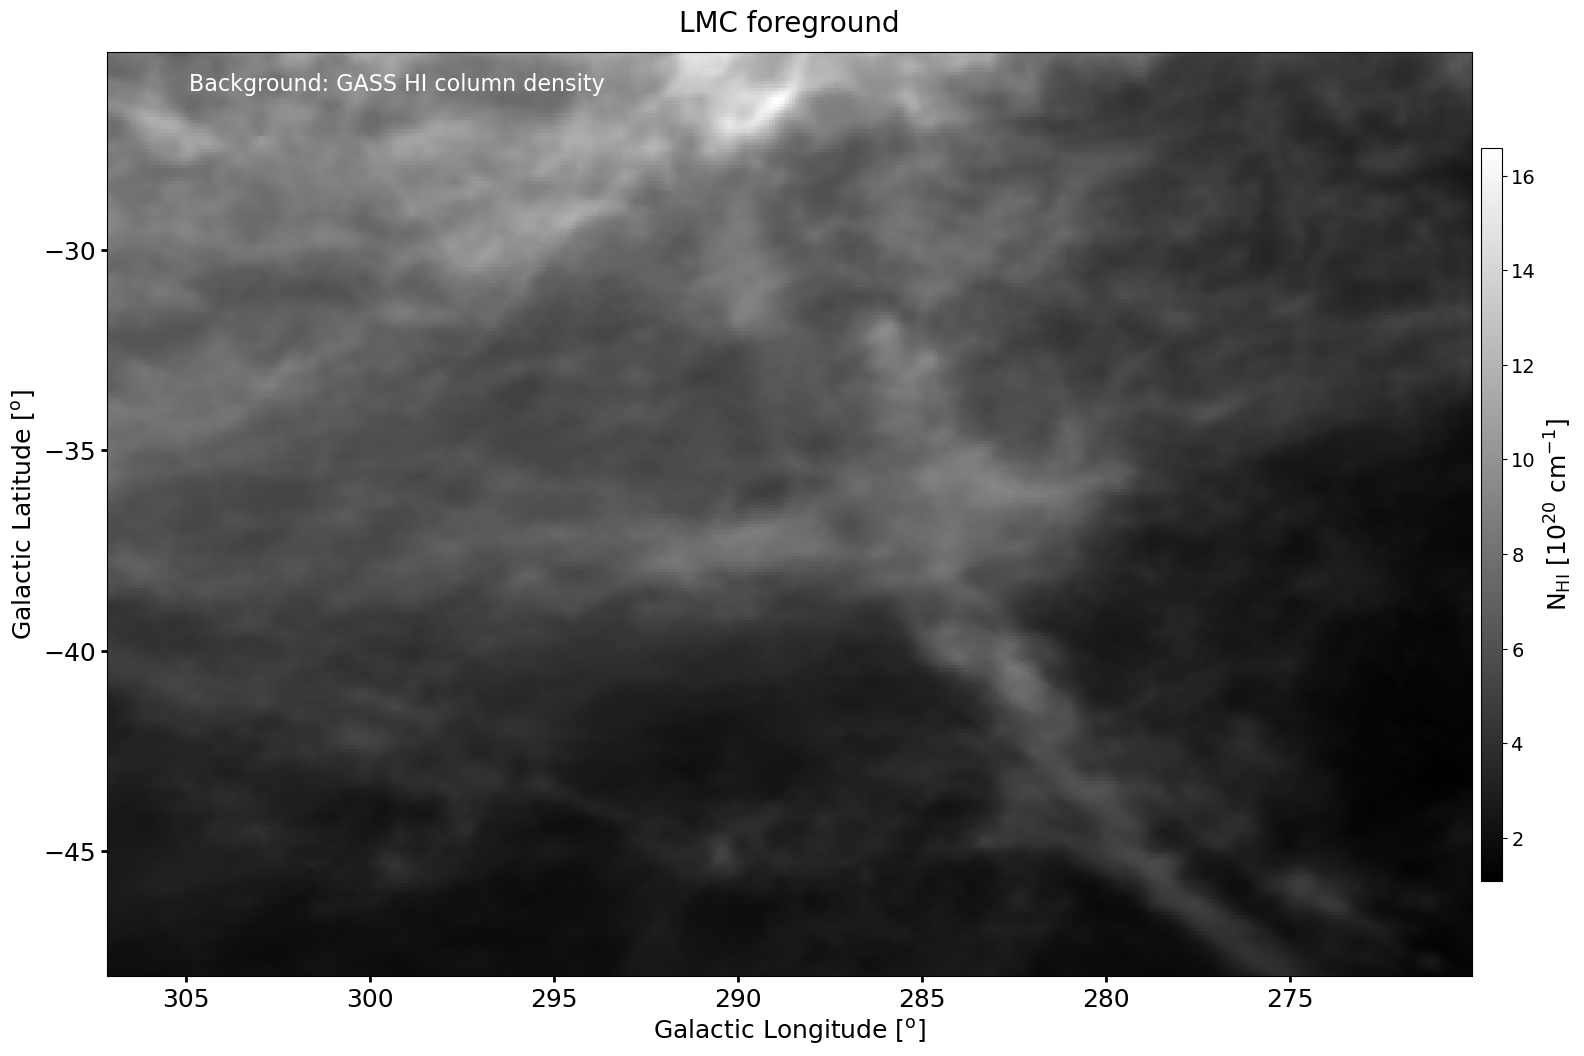

In [13]:
# Plot
fig = plt.figure(figsize=(18, 12))
ax = fig.add_subplot(111)

cm = mpl.cm.get_cmap('cool') # winter, cool, hsv

# Display map
minval = nhi_thin.min()
maxval = nhi_thin.max()

# im = ax.imshow(0.018224*m0, cmap='gray')
im = ax.pcolormesh(HI_GLON, HI_GLAT, nhi_thin, cmap='gray', vmin=minval, vmax=maxval)

# sct = ax.scatter(src_gl, src_gb, s=40, transform=ax.get_transform('galactic'), marker='o', c='b', alpha=0.8, label='MW')
# ax.scatter(289., -33., s=40, transform=ax.get_transform('galactic'), marker='o', c='m', label='MW')

# sct = ax.scatter(gl_ts, gb_ts,
#                   zorder=0, s=tscnm,
#                   c=tscnm, marker='o', cmap=cm,
#                   vmin=tsmin, vmax=tsmax,
#                   transform=ax.get_transform('galactic'),
#                   label='')


ploti, = plt.plot([], [], '', label=f"Background: GASS HI column density")
ploti.set_visible(False)


# Add axes labels
ax.set_xlabel(r"Galactic Longitude [$^\mathrm{o}$]", fontsize=18)
ax.set_ylabel(r"Galactic Latitude [$^\mathrm{o}$]", fontsize=18)

# ax.invert_yaxis()
ax.invert_xaxis()

# ax.set_ylim(-46.*u.deg,-27.*u.deg)

ax.tick_params(axis='x', labelsize=18, pad=4)
ax.tick_params(axis='y', labelsize=18)
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=4)
ax.tick_params(which='minor', length=2)

## Color bar
cbar = fig.colorbar(im, ax=ax, orientation='vertical', fraction=0.015, pad=0.006, aspect=35)
cbar.ax.set_ylabel(r'$\mathrm{N_{HI}}$ [10$^{20}$ cm$^{-1}$]', rotation=90, labelpad=5., fontsize=18)
cbar.ax.tick_params(labelsize=14)

# plt.title(f"LMC foreground: Sources with Absorption (LMC foreground), N = {n_abs_fg} ({np.round(100.*n_abs_fg/n_sources, 1) } %)", fontsize=20)
plt.title(f"LMC foreground", fontsize=20, pad=15)

plt.legend(loc='upper left', fancybox=False, framealpha=0.0, labelcolor='w', fontsize=16)
plt.show()

Opticall-thin N(HI) mean: 5.090000152587891
Opticall-thin N(HI) median: 4.71999979019165


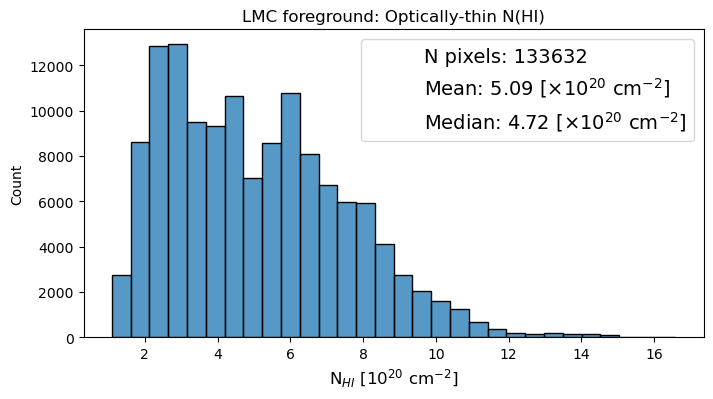

In [14]:
nhi_thin_LMC_fg = nhi_thin.flatten()
N_pixels = m0.shape[0] * m0.shape[1]
xmean = np.round(np.mean(nhi_thin_LMC_fg), 2)
xmedian = np.round(np.median(nhi_thin_LMC_fg), 2)

print(f"Opticall-thin N(HI) mean: {xmean}")
print(f"Opticall-thin N(HI) median: {xmedian}")

# Optically-thin HI column density
plt.figure(figsize=(8, 4))

sns.histplot(data=nhi_thin_LMC_fg, bins=30, kde=False)

ploti, = plt.plot([], [], '', label=f"N pixels: {N_pixels}")
ploti.set_visible(False)
ploti, = plt.plot([], [], '', label=r"Mean: 5.09 [$\times$10$^{20}$ cm$^{-2}$]")
ploti.set_visible(False)
ploti, = plt.plot([], [], '', label=r"Median: 4.72 [$\times$10$^{20}$ cm$^{-2}$]")
ploti.set_visible(False)
    
# for labeli,vali in zip(labels, stats_values):
#     ploti, = plt.plot([], [], '', label=f"{labeli} : {vali}")
#     ploti.set_visible(False)

plt.title(f'LMC foreground: Optically-thin N(HI)')
plt.xlabel(r'N$_{HI}$ [10$^{20}$ cm$^{-2}$]', fontsize=12)

plt.legend(loc='upper right', fontsize=14)
plt.show()

# Read GD results

In [15]:
bridge_fields = [38466, 38215, 38758, 38509]

In [16]:
csv_filename = os.path.join(gfit_path, "GD_result_table.csv")
# gfit_result_df.to_csv(csv_filename, index=False)
LMC_fg_GD_res_df = pd.read_csv(csv_filename)
print(f"df shape: {LMC_fg_GD_res_df.shape}")
nrows, ncols = LMC_fg_GD_res_df.shape
LMC_fg_GD_res_df.head()

df shape: (483, 35)


,comp_name,sbid,ra,dec,glon,glat,in_bridge,rating,flux_peak,mean_cont,...,nhiwnm,signhiwnm,fcnm,sigfcnm,Rfactor,sigRfactor,nhi,signhi,nhi_thin,signhi_thin
0,J004222-754838,38215,10.593081,-75.810688,303.671291,-41.304546,1,A,305.821991,0.001330,...,3.410674,0.006363,0.236043,0.008039,0.980426,0.007816,4.465300,0.035404,4.503674,0.006460
1,J005321-770019,38215,13.340055,-77.005322,302.790601,-40.122402,1,B,62.594002,0.000583,...,3.228791,0.009345,0.299737,0.087680,0.981586,0.082454,4.610511,0.388602,4.605203,0.007189
2,J005322-770014,38215,13.343918,-77.004017,302.789449,-40.123698,1,B,36.799999,0.000532,...,3.150759,0.013857,0.303779,0.092597,1.013505,0.089860,4.525516,0.401176,4.465215,0.007290
3,J005341-771713,38215,13.423181,-77.287058,302.770360,-39.840486,1,B,204.998001,0.001099,...,3.057638,0.007754,0.312231,0.033427,0.965557,0.030820,4.444806,0.141612,4.632826,0.005657
4,J005641-783945,38215,14.173549,-78.662596,302.602033,-38.462288,1,B,133.843994,0.000957,...,4.942118,0.023905,0.135294,0.007766,1.023467,0.008963,5.712906,0.049817,5.310683,0.006134


In [17]:
# RADEC coordinates
fg_ra = LMC_fg_GD_res_df['ra'].values
fg_dec = LMC_fg_GD_res_df['dec'].values

In [18]:
# Galactic coordinates of sightlines towards LMC fg
glon = LMC_fg_GD_res_df['glon'].values
glat = LMC_fg_GD_res_df['glat'].values
fcnm = LMC_fg_GD_res_df['fcnm'].values
sigfcnm = LMC_fg_GD_res_df['sigfcnm'].values

In [19]:
nhi = LMC_fg_GD_res_df['nhi'].values
signhi = LMC_fg_GD_res_df['signhi'].values

In [20]:
LMC_df = LMC_fg_GD_res_df[LMC_fg_GD_res_df['sbid'].isin(bridge_fields)]
src_gl_LMC = LMC_df['glon']
src_gb_LMC = LMC_df['glat']
n_abs_LMC_fg = len(src_gb_LMC)
print(f"Number of sightlines toward LMC foreground: {n_abs_LMC_fg}")

Number of sightlines toward LMC foreground: 272


In [21]:
LMC_df = LMC_fg_GD_res_df[LMC_fg_GD_res_df['in_bridge'] == 1]
src_gl_LMC = LMC_df['glon']
src_gb_LMC = LMC_df['glat']
n_abs_LMC_fg = len(src_gb_LMC)
print(f"Number of sightlines toward LMC foreground: {n_abs_LMC_fg}")

Number of sightlines toward LMC foreground: 272


In [22]:
# Approximate locations of LMC and SMC
SMC_xcirc, SMC_ycirc = cf.SMC['circ']
LMC_xcirc, LMC_ycirc = cf.LMC['circ']

In [23]:
bridge_df = LMC_fg_GD_res_df[~LMC_fg_GD_res_df['sbid'].isin(bridge_fields)]
src_gl_bridge = bridge_df['glon']
src_gb_bridge = bridge_df['glat']
n_abs_bridge_fg = len(src_gl_bridge)
print(f"Number of sightlines toward Bridge foreground: {n_abs_bridge_fg}")

Number of sightlines toward Bridge foreground: 211


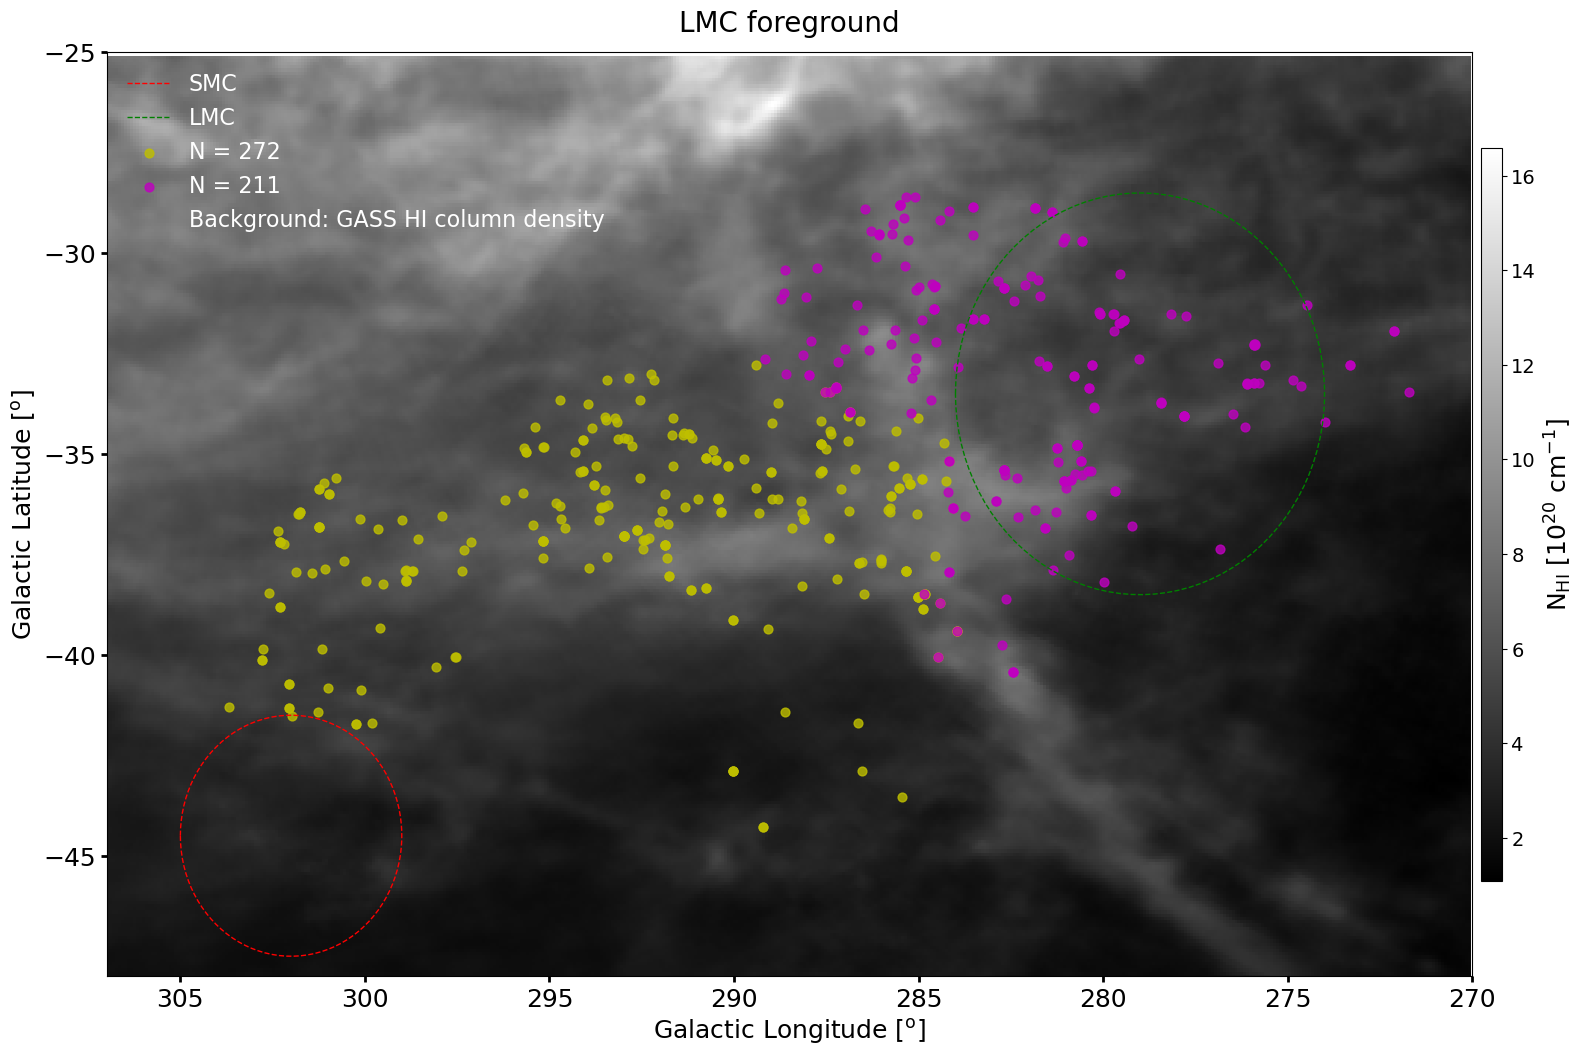

In [24]:
# Plot
fig = plt.figure(figsize=(18, 12))
ax = fig.add_subplot(111)

cm = mpl.cm.get_cmap('cool') # winter, cool, hsv

# Display map
minval = nhi_thin.min()
maxval = nhi_thin.max()

# im = ax.imshow(0.018224*m0, cmap='gray')
im = ax.pcolormesh(HI_GLON, HI_GLAT, nhi_thin, cmap='gray', vmin=minval, vmax=maxval)

# Approximate locations of LMC, SMC
ax.plot(SMC_xcirc, SMC_ycirc, lw=1., color='r', ls='--', label='SMC')
ax.plot(LMC_xcirc, LMC_ycirc, lw=1., color='g', ls='--', label='LMC')

ax.scatter(src_gl_LMC, src_gb_LMC, s=40,
           # transform=ax.get_transform('galactic'),
           marker='o', c='y', alpha=0.8,
           label=f'N = {n_abs_LMC_fg}')

ax.scatter(src_gl_bridge, src_gb_bridge, s=40,
           # transform=ax.get_transform('galactic'),
           marker='o', c='m', alpha=0.8,
           label=f'N = {n_abs_bridge_fg}')


ploti, = plt.plot([], [], '', label=f"Background: GASS HI column density")
ploti.set_visible(False)


# Add axes labels
ax.set_xlabel(r"Galactic Longitude [$^\mathrm{o}$]", fontsize=18)
ax.set_ylabel(r"Galactic Latitude [$^\mathrm{o}$]", fontsize=18)

# ax.invert_yaxis()
ax.invert_xaxis()

ax.set_xlim(307., 270.)
ax.set_ylim(-48., -25.)

ax.tick_params(axis='x', labelsize=18, pad=4)
ax.tick_params(axis='y', labelsize=18)
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=4)
ax.tick_params(which='minor', length=2)

## Color bar
cbar = fig.colorbar(im, ax=ax, orientation='vertical', fraction=0.015, pad=0.006, aspect=35)
cbar.ax.set_ylabel(r'$\mathrm{N_{HI}}$ [10$^{20}$ cm$^{-1}$]', rotation=90, labelpad=5., fontsize=18)
cbar.ax.tick_params(labelsize=14)

# plt.title(f"LMC foreground: Sources with Absorption (LMC foreground), N = {n_abs_fg} ({np.round(100.*n_abs_fg/n_sources, 1) } %)", fontsize=20)
plt.title(f"LMC foreground", fontsize=20, pad=15)

plt.legend(loc='upper left', fancybox=False, framealpha=0.0, labelcolor='w', fontsize=16)
plt.show()

# Read dust data

In [25]:
filename = os.path.join(lallement19_data_path, 'hpx_cube_Extinction_1200pc_nside128.fits')
filename

'/Users/kiemhiep/ANU/ASKAP/data/dust/lallement19/hpx_cube_Extinction_1200pc_nside128.fits'

In [26]:
# DA0/dd LAL                                                                                                                                                                                                                                                                      
hdu = fits.open(filename)                                                                                                                                                                                                                                         
data = hdu[0].data / 10.
data.shape

(196608, 120)

In [27]:
# hdr = hdu.header
# hdr

In [28]:
nrows, nd = data.shape
print('Nrows = %i, ndistances = %i' %(nrows, nd))

Nrows = 196608, ndistances = 120


In [29]:
d = 10.*np.arange(1., nd+1, 1)
d

array([  10.,   20.,   30.,   40.,   50.,   60.,   70.,   80.,   90.,
        100.,  110.,  120.,  130.,  140.,  150.,  160.,  170.,  180.,
        190.,  200.,  210.,  220.,  230.,  240.,  250.,  260.,  270.,
        280.,  290.,  300.,  310.,  320.,  330.,  340.,  350.,  360.,
        370.,  380.,  390.,  400.,  410.,  420.,  430.,  440.,  450.,
        460.,  470.,  480.,  490.,  500.,  510.,  520.,  530.,  540.,
        550.,  560.,  570.,  580.,  590.,  600.,  610.,  620.,  630.,
        640.,  650.,  660.,  670.,  680.,  690.,  700.,  710.,  720.,
        730.,  740.,  750.,  760.,  770.,  780.,  790.,  800.,  810.,
        820.,  830.,  840.,  850.,  860.,  870.,  880.,  890.,  900.,
        910.,  920.,  930.,  940.,  950.,  960.,  970.,  980.,  990.,
       1000., 1010., 1020., 1030., 1040., 1050., 1060., 1070., 1080.,
       1090., 1100., 1110., 1120., 1130., 1140., 1150., 1160., 1170.,
       1180., 1190., 1200.])

In [30]:
npix = int(nrows/12.)
npix

16384

In [31]:
# npix = 12 * nside**2
nside = int(np.sqrt(npix))
nside

128

In [32]:
# Create an empty Healpix map
dAdd = np.zeros(npix)

# Fill the map with the values at the specified pixel indices
# At a specific distance d_id = 3
dAdd = data[:, 3]

In [33]:
dAdd.shape

(196608,)

In [34]:
# npix = 12 * nside**2
nside = int(np.sqrt(196608/12))
nside

128

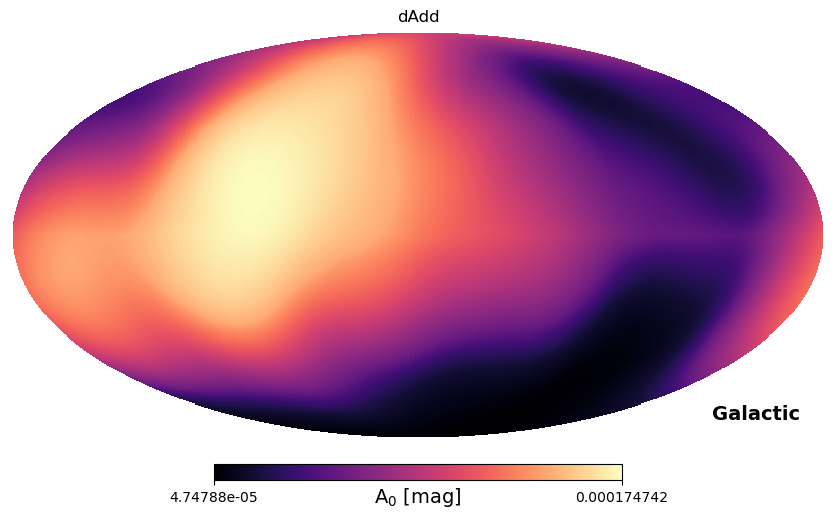

In [35]:
# Convert the Healpix map to a Mollweide projection
title = 'dAdd'
hp.mollview(dAdd, 
            title=title, 
            nest=False, 
            coord=['G'], 
            cmap='magma',
            norm='hist',
            unit='A$_0$ [mag]')
            # min=0.2, 
            # max=10.)

In [36]:
sum_dAdd = np.sum(data, axis=-1)

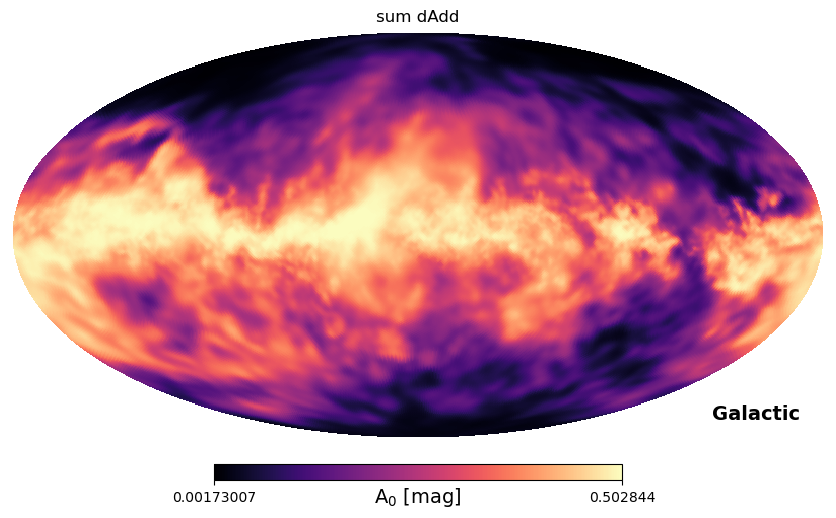

In [37]:
# Convert the Healpix map to a Mollweide projection
title = 'sum dAdd'
hp.mollview(sum_dAdd, 
            title=title, 
            nest=False, 
            coord=['G'], 
            cmap='magma',
            norm='hist',
            unit='A$_0$ [mag]')
            # min=0.2, 
            # max=10.)

In [38]:
nside  = hp.get_nside(dAdd)
nside

128

In [39]:
gl = 277.
gb = -35.

pix = hp.ang2pix(nside, gl, gb, lonlat=True, nest=False)
print(pix)
dAdd_los = np.array(data[pix, :]).squeeze()
print(dAdd_los.shape)

155274
(120,)


In [40]:
dAdd_los.shape

(120,)

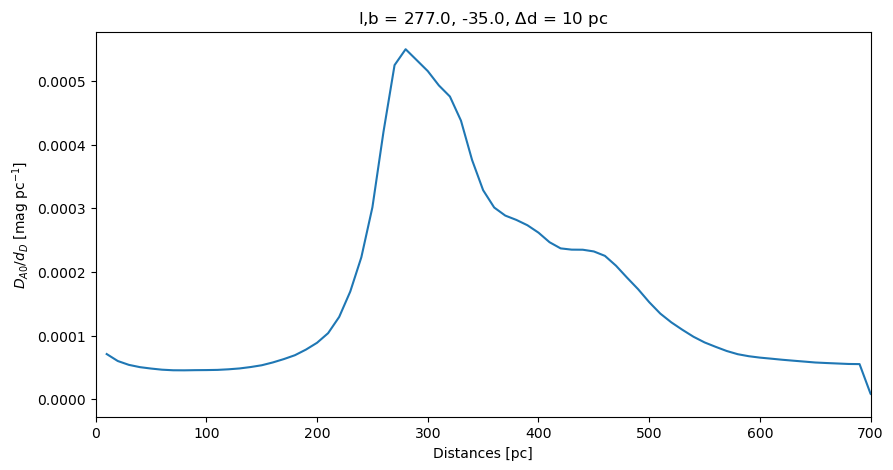

In [41]:
plt.figure(figsize=(10, 5))

plt.plot(d, dAdd_los)

plt.xlim(0, 700)

plt.title('l,b = %.1f, %.1f, $\Delta$d = 10 pc' % (gl, gb))
plt.xlabel('Distances [pc]')
plt.ylabel('$D_{A0}/d_{D}$ [mag pc$^{-1}$]')
plt.show()

In [42]:
# For LMC only
# lat_range = [-48., -25.]
# lon_range = [270., 310.]

# glon_mc = np.arange(270., 310., 0.1)
# glat_mc = np.arange(-48., -25., 0.1)

# For SMC only
glon_mc = np.arange(290., 315., 0.1)
glat_mc = np.arange(-52., -40, 0.1)

In [43]:
GLON, GLAT = np.meshgrid(glon_mc, glat_mc, indexing='ij')

In [44]:
GLAT.shape

(250, 120)

In [45]:
pix = hp.ang2pix(nside, GLON, GLAT, lonlat=True, nest=False)
pix.shape

(250, 120)

In [46]:
dAdd_siglines = np.array(data[pix, :]).squeeze()
print(dAdd_siglines.shape)

(250, 120, 120)


In [54]:
def plot_dust_profiles(data, x):
    h, w, _ = data.shape
    plt.figure(figsize=(10, 5))

    for i,j in np.ndindex(h, w):
        plt.plot(x, data[i, j, :], lw=0.5)

    plt.title('Dust density profiles in the LMC foreground: glon=[290, 315], glat=[-52, -40]')
    plt.xlabel('Distances [pc]')
    plt.ylabel('$D_{A0}/d_{D}$ [mag pc$^{-1}$]')
    plt.show()

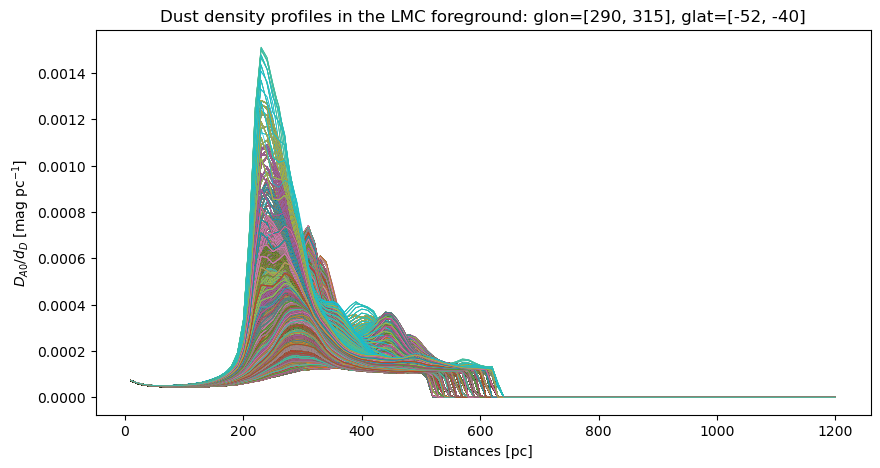

In [55]:
plot_dust_profiles(dAdd_siglines, d)

(1,)
(120,)


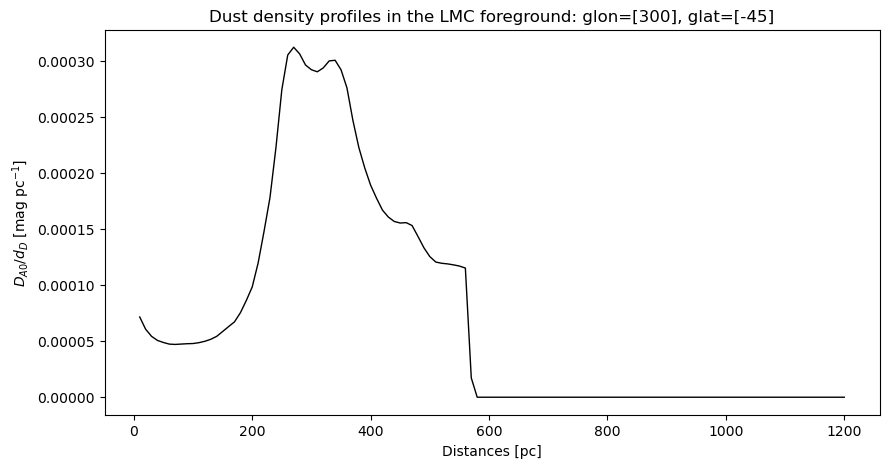

In [63]:
pix_los = hp.ang2pix(nside, [300.], [-45.], lonlat=True, nest=False)
print(pix_los.shape)

dAdd_los = np.array(data[pix_los, :]).squeeze()
print(dAdd_los.shape)

plt.figure(figsize=(10, 5))

plt.plot(d, dAdd_los, lw=1., color='k')

plt.title('Dust density profiles in the LMC foreground: glon=[300], glat=[-45]')
plt.xlabel('Distances [pc]')
plt.ylabel('$D_{A0}/d_{D}$ [mag pc$^{-1}$]')
plt.show()

In [64]:
sum_dAdd.shape

(196608,)

In [50]:
img = sum_dAdd[pix]*10
img.shape

(250, 120)

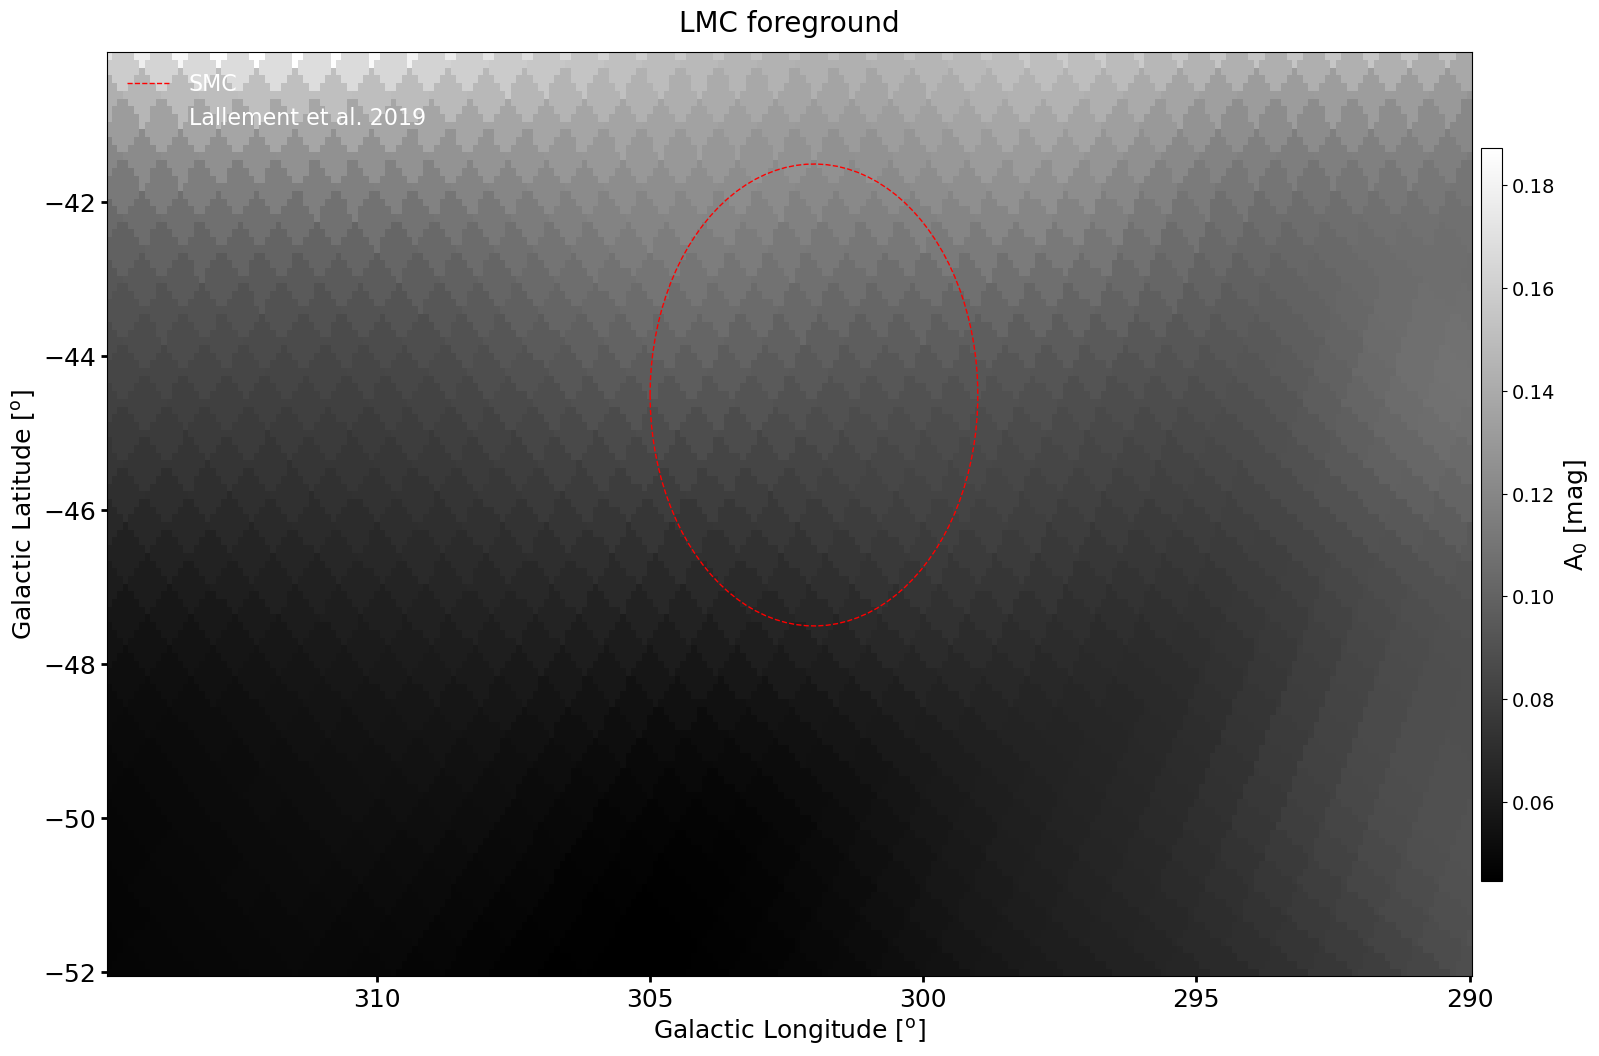

In [66]:
# Plot
fig = plt.figure(figsize=(18, 12))
ax = fig.add_subplot(111)

cm = mpl.cm.get_cmap('cool') # winter, cool, hsv

# Display map
minval = img.min()
maxval = img.max()

# im = ax.imshow(img, cmap='gray')
im = ax.pcolormesh(GLON, GLAT, img, cmap='gray', vmin=minval, vmax=maxval)

# Approximate locations of LMC, SMC
ax.plot(SMC_xcirc, SMC_ycirc, lw=1., color='r', ls='--', label='SMC')
# ax.plot(LMC_xcirc, LMC_ycirc, lw=1., color='g', ls='--', label='LMC')

# Absorption los
# ax.scatter(src_gl_LMC, src_gb_LMC, s=40,
#            # transform=ax.get_transform('galactic'),
#            marker='o', c='y', alpha=0.8,
#            label=f'N = {n_abs_LMC_fg}')

# ax.scatter(src_gl_bridge, src_gb_bridge, s=40,
#            # transform=ax.get_transform('galactic'),
#            marker='o', c='m', alpha=0.8,
#            label=f'N = {n_abs_bridge_fg}')

ploti, = plt.plot([], [], '', label=f"Lallement et al. 2019")
ploti.set_visible(False)


# Add axes labels
ax.set_xlabel(r"Galactic Longitude [$^\mathrm{o}$]", fontsize=18)
ax.set_ylabel(r"Galactic Latitude [$^\mathrm{o}$]", fontsize=18)

# ax.invert_yaxis()
ax.invert_xaxis()

# ax.set_ylim(-46.*u.deg,-27.*u.deg)

ax.tick_params(axis='x', labelsize=18, pad=4)
ax.tick_params(axis='y', labelsize=18)
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=4)
ax.tick_params(which='minor', length=2)

## Color bar
cbar = fig.colorbar(im, ax=ax, orientation='vertical', fraction=0.015, pad=0.006, aspect=35)
cbar.ax.set_ylabel(r'$\mathrm{A_{0}}$ [mag]', rotation=90, labelpad=5., fontsize=18)
cbar.ax.tick_params(labelsize=14)

# plt.title(f"LMC foreground: Sources with Absorption (LMC foreground), N = {n_abs_fg} ({np.round(100.*n_abs_fg/n_sources, 1) } %)", fontsize=20)
plt.title(f"LMC foreground", fontsize=20, pad=15)

plt.legend(loc='upper left', fancybox=False, framealpha=0.0, labelcolor='w', fontsize=16)
plt.show()

In [ ]:
print('End--')